In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
n2i = {s:i+1 for i, s in enumerate(chars)}
n2i['.'] = 0
i2n = {i: s for s, i in n2i.items()}
vocab_size = len(i2n)

In [4]:
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            idx = n2i[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(i2n[i] for i in context), '-->', i2n[idx])
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y



n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x, y in zip(X_train[:10], y_train[:10]):
    print(''.join(i2n[ix.item()] for ix in x), '-->', i2n[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o


In [7]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)
    

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xstd = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xstd = self.running_std
        
        xhat = (x - xmean) / torch.sqrt(xstd + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_std = (1 - self.momentum) * self.running_std + self.momentum * xstd
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, idx):
        self.out = self.weight[idx]
        return self.out
    
    def parameters(self):
        return [self.weight]


class Flatten_cons:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42);

In [9]:
n_emb = 24
n_hidden = 128
block_size = 8


model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten_cons(2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten_cons(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Flatten_cons(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
(sum(p.nelement() for p in parameters))

76579

In [10]:
steps = 200_000
batch_size = 32
stepi = []
losses = []

for i in range(steps):
    idx = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, yb = X_train[idx], y_train[idx]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    if i % 10000 == 0:
        print(f'{i}/{steps} - loss:{loss}')
    losses.append(loss.log10().mean())
    stepi.append(i)


0/200000 - loss:3.3167154788970947
10000/200000 - loss:2.0576295852661133
20000/200000 - loss:2.0723211765289307
30000/200000 - loss:2.5133700370788574
40000/200000 - loss:2.1476097106933594
50000/200000 - loss:1.783566951751709
60000/200000 - loss:2.2591874599456787
70000/200000 - loss:1.9330682754516602
80000/200000 - loss:1.6874682903289795
90000/200000 - loss:2.0395092964172363
100000/200000 - loss:1.7735745906829834
110000/200000 - loss:1.9569320678710938
120000/200000 - loss:1.7464805841445923
130000/200000 - loss:1.8125674724578857
140000/200000 - loss:1.7405669689178467
150000/200000 - loss:1.7466323375701904
160000/200000 - loss:1.8805551528930664
170000/200000 - loss:1.6265844106674194
180000/200000 - loss:1.6476023197174072
190000/200000 - loss:1.855502724647522


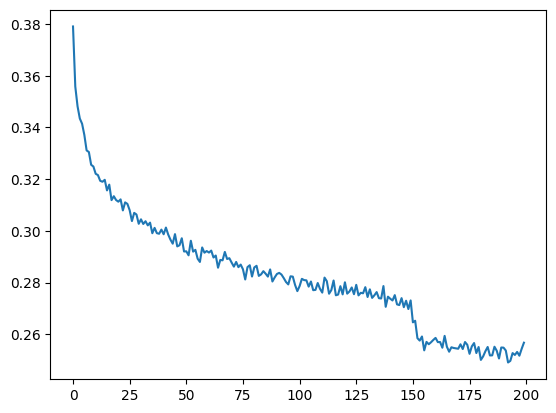

In [11]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [12]:
for layer in model.layers:
  layer.training = False

In [13]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690287828445435
val 1.9936511516571045


In [14]:

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(i2n[i] for i in out))

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.
